In [1]:
# -*- coding: utf-8 -*-
"""
Demo on data evaluation

@author: vpeterson
"""

# check predictions
import matplotlib.pyplot as plt
import numpy as np 
font = {'size'   : 14}
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, mean_absolute_error, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import sys
sys.path.insert(1, './utilities')
     
from Generator import SeizureDatasetLabelTime, StatsRecorder, normalize_spec, scale_spec, permute_spec, smoothing_label
from Model import iESPnet
import IO
import pandas as pd
from TrainEval import test_model, train_model, get_thr_output, get_performance_indices
import seaborn as sb

In [2]:
FREQ_MASK_PARAM = 10
TIME_MASK_PARAN = 20
N_CLASSES = 1
learning_rate = 1e-3
batch_size = 128
epochs = 20
num_workers = 4
hparams = {
         "n_cnn_layers": 3,
        "n_rnn_layers": 3,
        "rnn_dim": [150, 100, 50],
        "n_class": N_CLASSES,
        "out_ch": [8,8,16],
        "dropout": 0.3,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "epochs": epochs
        }


SPE_DIR = './Data/'
# get metadata file
# this is a csv file this the rns_id, file name (data), label and time infor
meta_data_file = './Data/Metadata/allfiles_metadata.csv'
df = pd.read_csv(meta_data_file)

save_path = './Results/'
df_subjects = pd.read_csv('./Data/Metadata/subjects_info.csv')

RNSIDS = df_subjects.rns_deid_id

In [5]:
s = 23
model = iESPnet(hparams['n_cnn_layers'],
                       hparams['n_rnn_layers'],
                       hparams['rnn_dim'],
                       hparams['n_class'],
                       hparams['out_ch'],
                       hparams['dropout'],
                       )
        
save_models = save_path + RNSIDS[s] +'/models/'


print('Running testing for subject ' + RNSIDS[s] + ' [s]: ' + str(s))


train_df = df.copy()
# define train, val and test from df
test_df = df[df.rns_id==RNSIDS[s]]
test_df.reset_index(drop=True, inplace=True)

train_df.drop(train_df[train_df['rns_id'] == RNSIDS[s]].index, inplace = True)


#%% eval        
best_thr = 0.2
best_path = save_models + 'model_opt.pth'

test_df['epoch'] = test_df.data.apply(lambda x: x.split("_")[2])
test_epochs = test_df.epoch.unique()
    
for epoch_counter in test_epochs:
    if epoch_counter == '20170927-1':
        # here se show results on one PE
        test_df_pe = test_df[test_df['epoch'] == epoch_counter]

        test_data_pe = SeizureDatasetLabelTime(file=test_df_pe,
                            root_dir=SPE_DIR,
                            transform=None,
                            target_transform=smoothing_label()  
                            )


        # in testing
        outputs_test=test_model(model, hparams, best_path, test_data_pe)
        prediction_te = get_performance_indices(outputs_test['y_true'], outputs_test['y_prob'], best_thr)

Running testing for subject PIT-RNS9536 [s]: 23
Using cuda device


C:\Users\vp820\AppData\Local\Temp\8/ipykernel_40208/3977202083.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['epoch'] = test_df.data.apply(lambda x: x.split("_")[2])


Testing process has finished.
Accuracy : 0.94 F1 : 0.95 Precission : 0.96 Recall : 0.94 MAEtime : 7.05


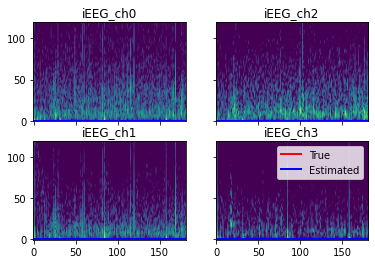

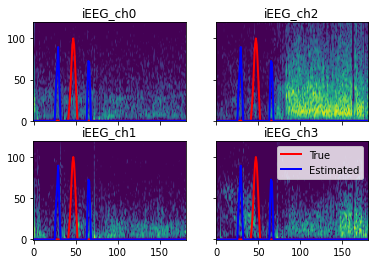

In [40]:
np.random.seed(0)
idx_ = np.random.choice(range(len(test_df_pe)), 2)
for ii, val in enumerate(idx_):
    image_arr = test_df_pe.iloc[val].get('data')

    file_name = SPE_DIR + image_arr + '.npy'
    dic = np.load(file_name, allow_pickle=True)
    data = dic.item().get('spectrogram')
    label = dic.item().get('label')
    true_l = prediction_te['y_true'][val]
    estimated_l = prediction_te['y_pred'][val].numpy()
    
    fig, axs = plt.subplots(2, 2)

    for i in range(4):
        if i<2:
            axs[i,0].imshow(data[i], origin='lower', aspect='auto')
            axs[i,0].plot(true_l*100, color='red', linewidth=2, label='True')
            axs[i,0].set_title('iEEG_ch'+  str(i))
            axs[i,0].plot(estimated_l*100, color='blue', linewidth=2, label='Estimated')

        else:
            axs[np.mod(i,2),1].imshow(data[i], origin='lower', aspect='auto')
            axs[np.mod(i,2),1].plot(true_l*100, color='red', linewidth=2, label='True')       
            axs[np.mod(i,2),1].plot(estimated_l*100, color='blue', linewidth=2, label='Estimated')
            axs[np.mod(i,2),1].set_title('iEEG_ch'+  str(i))
    for ax in axs.flat:
        ax.label_outer()
        
    plt.legend();